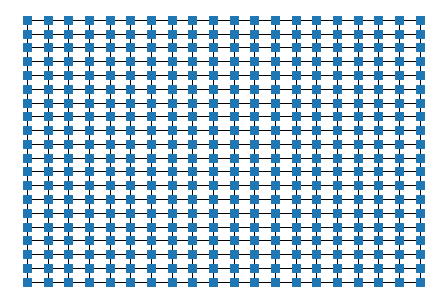

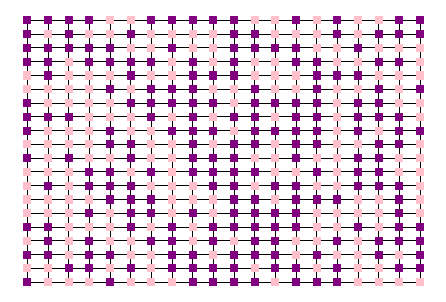

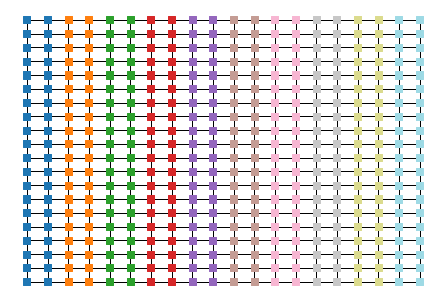

In [6]:
import random

import matplotlib.pyplot as plt
from functools import partial
import networkx as nx
import numpy as np

from gerrychain import MarkovChain, Graph
from gerrychain.constraints import (
    Validator,
    single_flip_contiguous, UpperBound,
    within_percent_of_ideal_population,
)
from gerrychain.proposals import propose_random_flip
from gerrychain.accept import always_accept
from gerrychain.updaters import (
    Tally,
    Election,
    boundary_nodes,
    cut_edges,
    cut_edges_by_part,
    exterior_boundaries,
    interior_boundaries,
    perimeter,
)
from gerrychain.partition import Partition, GeographicPartition
from gerrychain.proposals import recom
from gerrychain.metrics import mean_median, efficiency_gap, polsby_popper, compactness
from gerrychain.grid import Grid


# BUILD GRAPH

gn = 2
k = 10
ns = 50
p = 0.5

graph = nx.grid_graph([k * gn, k * gn])


for n in graph.nodes():
    graph.nodes[n]["population"] = 1

    if random.random() < p:
        graph.nodes[n]["pink"] = 1
        graph.nodes[n]["purple"] = 0
    else:
        graph.nodes[n]["pink"] = 0
        graph.nodes[n]["purple"] = 1
    if 0 in n or k * gn - 1 in n:
        graph.nodes[n]["boundary_node"] = True
        graph.nodes[n]["boundary_perim"] = 1

    else:
        graph.nodes[n]["boundary_node"] = False

# this part adds queen adjacency
# for i in range(k*gn-1):
#    for j in range(k*gn):
#        if j<(k*gn-1):
#            graph.add_edge((i,j),(i+1,j+1))
#            graph[(i,j)][(i+1,j+1)]["shared_perim"]=0
#        if j >0:
#            graph.add_edge((i,j),(i+1,j-1))
#            graph[(i,j)][(i+1,j-1)]["shared_perim"]=0


# ######### BUILD ASSIGNMENT
cddict = {x: int(x[0] / gn) for x in graph.nodes()}

# #####PLOT GRIDS

plt.figure()
nx.draw(graph, pos={x: x for x in graph.nodes()}, node_size=ns, node_shape="s")
plt.show()

cdict = {1: "pink", 0: "purple"}

plt.figure()
nx.draw(
    graph,
    pos={x: x for x in graph.nodes()},
    node_color=[cdict[graph.nodes[x]["pink"]] for x in graph.nodes()],
    node_size=ns,
    node_shape="s",
)
plt.show()

plt.figure()
nx.draw(
    graph,
    pos={x: x for x in graph.nodes()},
    node_color=[cddict[x] for x in graph.nodes()],
    node_size=ns,
    node_shape="s",
    cmap="tab20",
)
plt.show()



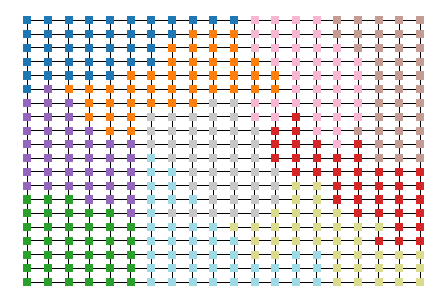

[2, 2, 2, 2, 2, 2, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 2, 2, 2, 2, 2, 2, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 2, 2, 2, 2, 2, 2, 9, 9, 9, 9, 9, 8, 8, 9, 9, 8, 8, 8, 8, 8, 2, 2, 2, 2, 2, 2, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 3, 3, 3, 2, 2, 2, 2, 2, 2, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 2, 2, 2, 2, 2, 4, 9, 7, 7, 7, 7, 7, 8, 8, 8, 8, 3, 3, 3, 3, 2, 2, 2, 4, 4, 4, 9, 9, 9, 7, 7, 7, 7, 8, 8, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 9, 9, 7, 7, 7, 7, 7, 8, 8, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 9, 9, 7, 7, 7, 7, 7, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 9, 7, 7, 7, 7, 7, 3, 3, 3, 3, 3, 5, 5, 5, 4, 4, 4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 3, 3, 3, 6, 3, 5, 5, 5, 4, 4, 4, 4, 1, 1, 7, 7, 7, 7, 7, 7, 3, 3, 6, 6, 5, 5, 5, 5, 4, 4, 4, 1, 1, 1, 7, 7, 7, 7, 7, 6, 6, 3, 6, 6, 6, 5, 5, 5, 4, 4, 4, 1, 1, 1, 1, 1, 1, 7, 7, 6, 6, 6, 6, 6, 6, 5, 5, 5, 0, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 6, 5, 5, 5, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 6, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 6, 

In [7]:
# ###CONFIGURE UPDATERS


def step_num(partition):
    parent = Partition.parent
    if not parent:
        return 0
    return parent["step_num"] + 1


updaters = {
    "population": Tally("population"), 
    "cut_edges": cut_edges,
    "step_num": step_num,
    "Pink-Purple": Election("Pink-Purple", {"Pink": "pink", "Purple": "purple"}),
}


# ########BUILD PARTITION

grid_partition = Partition(graph, assignment=cddict, updaters=updaters)

#print(compactness.polsby_popper(grid_partition))

kstar=1 #the compactness factor we want to use


# ADD CONSTRAINTS
popbound = within_percent_of_ideal_population(grid_partition, 0.1)
compactness_bound = UpperBound(
    lambda p: len(p["cut_edges"]),
    kstar*len(grid_partition["cut_edges"])
)

# ########Setup Proposal
ideal_population = sum(grid_partition["population"].values()) / len(grid_partition)

tree_proposal = partial(
    recom,
    pop_col="population",
    pop_target=ideal_population,
    epsilon=0.05,
    node_repeats=1,
)

# ######BUILD MARKOV CHAINS

#Validator([popbound, compactness_bound]),

#initial_state=part

recom_chain = MarkovChain(
    tree_proposal,
    Validator([popbound]),
    accept=always_accept,
    initial_state=grid_partition, #can use any other starting point, if needed
    total_steps=40,
)

# ########Run MARKOV CHAINS

rsw = []
rmm = []
reg = []
rce = []
rpp = []
mapslist = []
myfile = open('new20_20_10.txt', 'w')


for part in recom_chain:
    #rsw.append(part["Pink-Purple"].wins("Pink"))
    #rmm.append(mean_median(part["Pink-Purple"]))
    #reg.append(efficiency_gap(part["Pink-Purple"]))
    #rce.append(len(part["cut_edges"]))
    #rpp.append(compactness.polsby_popper(part))
    onegrid = Grid((k * gn, k * gn), assignment = part.assignment)
    onemap = list(np.concatenate(onegrid.as_list_of_lists()).flat)
    mapslist.append(onemap)
    myfile.write("%s\n" % onemap)
    
    # plt.figure()
    # nx.draw(
    #     graph,
    #     pos={x: x for x in graph.nodes()},
    #     node_color=[dict(part.assignment)[x] for x in graph.nodes()],
    #     node_size=ns,
    #     node_shape="s",
    #     cmap="tab20",
    # )
    # plt.savefig(f"./Figures/recom_{part['step_num']:02d}.png")
    # plt.close()
myfile.close()

plt.figure()
nx.draw(
    graph,
    pos={x: x for x in graph.nodes()},
    node_color=[dict(part.assignment)[x] for x in graph.nodes()],
    node_size=ns,
    node_shape="s" , cmap="tab20",
)
plt.show()
print(onemap)

In [8]:
fin = open("new20_20_10.txt", "rt")
data = fin.read()
data = data.replace('[', '')
data = data.replace(']', '')
fin.close()
fin = open("new20_20_10.txt", "wt")
fin.write(data)
fin.close()